Time to compare cost of living around the world.

Our dataset will be used from website https://www.numbeo.com/cost-of-living/


Let's read collected data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import geopandas as gpd
from IPython.display import display, HTML
import requests

In [2]:
file = r'C:\Users\rocze\Desktop\pythonProject\COL.json'

In [3]:
data = pd.read_json(file)
print(data)

        CountryName Meal, Inexpensive Restaurant  \
0       Afghanistan                       1.67 $   
1     Aland Islands                      13.09 $   
2           Albania                       5.51 $   
3          Alderney                      22.32 $   
4           Algeria                       2.19 $   
..              ...                          ...   
229         Vietnam                       2.12 $   
230  Western Sahara                       3.20 $   
231           Yemen                       5.99 $   
232          Zambia                       3.67 $   
233        Zimbabwe                       6.00 $   

    Meal for 2 People, Mid-range Restaurant, Three-course  \
0                                               7.78 $      
1                                              64.10 $      
2                                              27.57 $      
3                                              72.38 $      
4                                              14.63 $      
..       

That's a lot of data, we should focus of few columns.

In [4]:
selectedData = data[['CountryName','Coke/Pepsi (0.33 liter bottle)','Water (0.33 liter bottle)','Rice (white), (1kg)','1 Pair of Nike Running Shoes (Mid-Range)','Apartment (1 bedroom) in City Centre','Apartment (3 bedrooms) in City Centre','Price per Square Meter to Buy Apartment in City Centre','Average Monthly Net Salary (After Tax)']]
print(selectedData)

        CountryName Coke/Pepsi (0.33 liter bottle) Water (0.33 liter bottle)  \
0       Afghanistan                         0.35 $                    0.16 $   
1     Aland Islands                         2.24 $                    1.74 $   
2           Albania                         1.32 $                    0.63 $   
3          Alderney                         1.99 $                    1.01 $   
4           Algeria                         0.48 $                    0.20 $   
..              ...                            ...                       ...   
229         Vietnam                         0.53 $                    0.32 $   
230  Western Sahara                         0.53 $                    0.32 $   
231           Yemen                         1.37 $                    0.67 $   
232          Zambia                         0.83 $                    0.46 $   
233        Zimbabwe                         0.65 $                    0.47 $   

    Rice (white), (1kg) 1 Pair of Nike 

But let's first clear our data, we have to remove some things from our table

In [5]:
selectedData = selectedData.applymap(lambda x: x.replace('\u00a0$', '') if isinstance(x, str) else x)
selectedData = selectedData.applymap(lambda x: x.replace(',', '') if isinstance(x, str) else x)
selectedData.iloc[:, 1:] = selectedData.iloc[:, 1:].apply(lambda x: pd.to_numeric(x, errors='coerce'))
print(selectedData)

        CountryName Coke/Pepsi (0.33 liter bottle) Water (0.33 liter bottle)  \
0       Afghanistan                           0.35                      0.16   
1     Aland Islands                           2.24                      1.74   
2           Albania                           1.32                      0.63   
3          Alderney                           1.99                      1.01   
4           Algeria                           0.48                       0.2   
..              ...                            ...                       ...   
229         Vietnam                           0.53                      0.32   
230  Western Sahara                           0.53                      0.32   
231           Yemen                           1.37                      0.67   
232          Zambia                           0.83                      0.46   
233        Zimbabwe                           0.65                      0.47   

    Rice (white), (1kg) 1 Pair of Nike 

Therefore we need to change the type of columns from object to numerical

In [6]:
selectedData['Coke/Pepsi (0.33 liter bottle)'] = selectedData['Coke/Pepsi (0.33 liter bottle)'].astype(float)
selectedData['Water (0.33 liter bottle)'] = selectedData['Water (0.33 liter bottle)'].astype(float)
selectedData['Rice (white), (1kg)'] = selectedData['Rice (white), (1kg)'].astype(float)
selectedData['1 Pair of Nike Running Shoes (Mid-Range)'] = selectedData['1 Pair of Nike Running Shoes (Mid-Range)'].astype(float)
selectedData['Apartment (1 bedroom) in City Centre'] = selectedData['Apartment (1 bedroom) in City Centre'].astype(float)
selectedData['Apartment (3 bedrooms) in City Centre'] = selectedData['Apartment (3 bedrooms) in City Centre'].astype(float)
selectedData['Price per Square Meter to Buy Apartment in City Centre'] = selectedData['Price per Square Meter to Buy Apartment in City Centre'].astype(float)
selectedData['Average Monthly Net Salary (After Tax)'] = selectedData['Average Monthly Net Salary (After Tax)'].astype(float)

In [7]:
selectedData.dtypes

CountryName                                                object
Coke/Pepsi (0.33 liter bottle)                            float64
Water (0.33 liter bottle)                                 float64
Rice (white), (1kg)                                       float64
1 Pair of Nike Running Shoes (Mid-Range)                  float64
Apartment (1 bedroom) in City Centre                      float64
Apartment (3 bedrooms) in City Centre                     float64
Price per Square Meter to Buy Apartment in City Centre    float64
Average Monthly Net Salary (After Tax)                    float64
dtype: object

Our columns names are little to long.

In [8]:
selectedData.columns=['Country','Coke 0.33l','Water 0.33l','Rice 1kg','Nike Runners','1B Apartment','3B Apartment','1SM Price in Center','Avg Salary']
print(selectedData)

            Country  Coke 0.33l  Water 0.33l  Rice 1kg  Nike Runners  \
0       Afghanistan        0.35         0.16      1.20         29.64   
1     Aland Islands        2.24         1.74      2.07        117.51   
2           Albania        1.32         0.63      1.42         74.80   
3          Alderney        1.99         1.01       NaN           NaN   
4           Algeria        0.48         0.20      1.09         65.82   
..              ...         ...          ...       ...           ...   
229         Vietnam        0.53         0.32      0.97         93.32   
230  Western Sahara        0.53         0.32      1.71         69.44   
231           Yemen        1.37         0.67      4.00         74.23   
232          Zambia        0.83         0.46      1.83         90.18   
233        Zimbabwe        0.65         0.47      1.49         39.44   

     1B Apartment  3B Apartment  1SM Price in Center  Avg Salary  
0           93.89        226.32               614.26      181.99  
1

For our visualization we need world map

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_file("world-countries.json", driver="GeoJSON")

In [11]:
map=r"C:\Users\rocze\world-countries.json"
m = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=map,
    data=selectedData,
    columns=["Country", "Avg Salary"],
    key_on="feature.properties.name",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Average Salary (USD)",
    reset=True
).add_to(m)
m.save("avg_salary_map.html")

Something wrong is with USA and other names, let's fix it!

In [9]:
row = selectedData.loc[selectedData['Country'] == "United States"]
selectedData.at[row.index[0], 'Country'] = 'United States of America'
row2 = selectedData.loc[selectedData['Country'] == "Czech Republic"]
selectedData.at[row2.index[0], 'Country'] = 'Czechia'
row3 = selectedData.loc[selectedData['Country'] == "Kosovo (Disputed Territory)"]
selectedData.at[row3.index[0], 'Country'] = 'Kosovo'
row4 = selectedData.loc[selectedData['Country'] == "Republic Of Congo"]
selectedData.at[row4.index[0], 'Country'] = 'Dem. Rep. Congo'
row5 = selectedData.loc[selectedData['Country'] == "South Sudan"]
selectedData.at[row5.index[0], 'Country'] = 'S. Sudan'
row6 = selectedData.loc[selectedData['Country'] == "Bosnia And Herzegovina"]
selectedData.at[row6.index[0], 'Country'] = 'Bosnia and Herz.'

Here is the map we created:
https://github.com/Alcosmao/CostOfLifeAroundTheWorld/blob/main/avg_salary_map.html

In [12]:
### IN PROGRESS ###
html_file_url = 'https://raw.githubusercontent.com/Alcosmao/CostOfLifeAroundTheWorld/blob/main/avg_salary_map.html'
html_content = requests.get(html_file_url).text
display(HTML(html_content))

Okay, now time to see how many years we need to save money to buy a 72m2 flat in city center, taking in consideration that we can save around 20% of our monthly wage

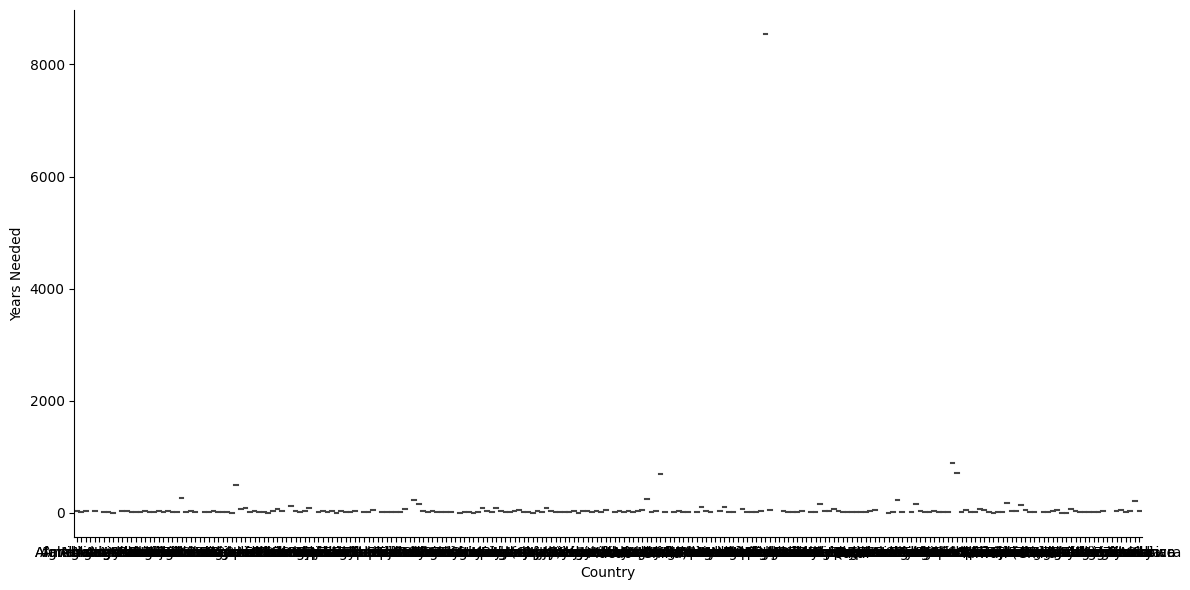

In [13]:
selectedData["72m2 Flat Price"] = 72 * selectedData["1SM Price in Center"]
selectedData["Years Needed"] = selectedData["72m2 Flat Price"] / (selectedData["Avg Salary"] * 12 * 0.8)
sns.catplot(x="Country", y="Years Needed", kind="violin", data=selectedData, height=6, aspect=2)
plt.show()

In [15]:
selectedColumns = selectedData[["Country", "Avg Salary","1SM Price in Center","Years Needed"]]
print(selectedColumns)


            Country  Avg Salary  1SM Price in Center  Years Needed
0       Afghanistan      181.99               614.26     25.314303
1     Aland Islands     2599.57              2848.85      8.219196
2           Albania      420.96              1747.62     31.136331
3          Alderney         NaN                  NaN           NaN
4           Algeria      263.73              1047.51     29.789273
..              ...         ...                  ...           ...
229         Vietnam      445.56              2754.98     46.373889
230  Western Sahara      213.66               598.26     21.000421
231           Yemen      378.65              1304.22     25.832959
232          Zambia      396.94             10763.91    203.379163
233        Zimbabwe      295.45              1069.10     27.139110

[234 rows x 4 columns]


Honestly, we cannot see anything here, lets visualize data fot top and bottom ten results.

C:\Users\rocze\AppData\Local\Temp\ipykernel_46952\2754696310.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(longestTen["Country"] + shortestTen["Country"])


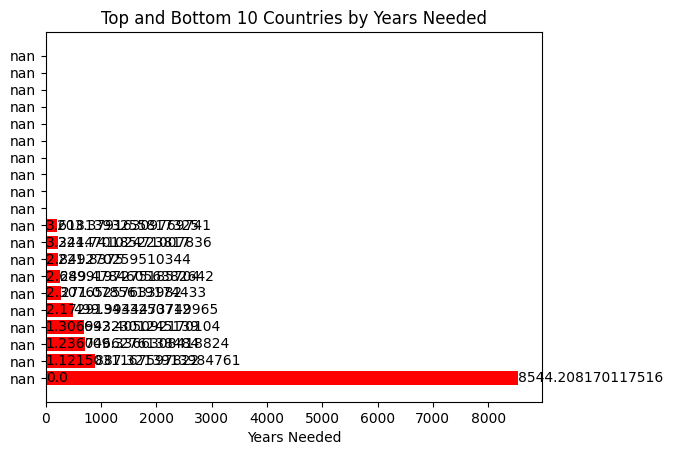

In [18]:
longestTen = selectedData.nlargest(10, "Years Needed")
shortestTen = selectedData.nsmallest(10, "Years Needed")
fig, ax = plt.subplots()
ax.barh(longestTen["Country"], longestTen["Years Needed"], color='red')
ax.barh(shortestTen["Country"], shortestTen["Years Needed"], color='blue')
for i, (value, country) in enumerate(zip(longestTen["Years Needed"], longestTen["Country"])):
    ax.text(value, i, str(value), ha='left', va='center')
for i, (value, country) in enumerate(zip(shortestTen["Years Needed"], shortestTen["Country"])):
    ax.text(value, i, str(value), ha='left', va='center')
ax.set_title("Top and Bottom 10 Countries by Years Needed")
ax.set_xlabel("Years Needed")
ax.set_yticklabels(longestTen["Country"] + shortestTen["Country"])
plt.show()